1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

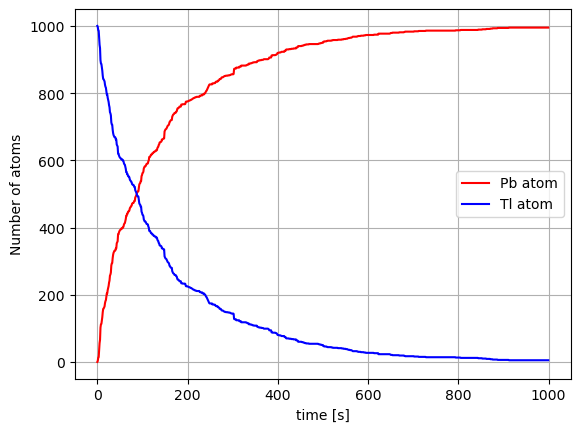

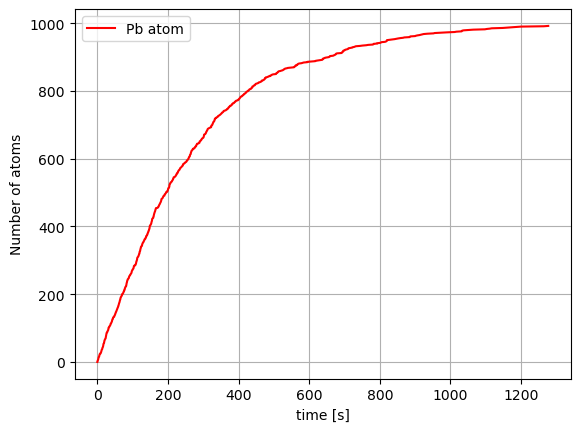

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random
tau=3.052*60
N_thallium=1000
N_lead=0
tmax=1000
def p(t):
    return 1-2**(-t/tau)
def p_i(u):
    return (-tau * math.log(1 - u) / math.log(2))

tpoints=np.arange(0.0,tmax,1.0)
Tlpoints=[]
Pbpoints=[]

for t in tpoints:
    Tlpoints.append(N_thallium)
    Pbpoints.append(N_lead)
    decay=0
    for i in range(N_thallium):
        if np.random.random() < p(1):
            decay+=1
            N_thallium-=decay
            N_lead+=decay
plt.figure()
plt.plot(tpoints, Pbpoints, c='red')
plt.plot(tpoints, Tlpoints, c='blue')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Number of atoms')
plt.legend(['Pb atom', 'Tl atom'])
plt.show()

N=1000
n=int(7.0*tau)
n_r=np.random.random(1000)
t=np.array([p_i(x) for x in n_r])
t_sort=np.sort(t)
tl = 1000 * np.ones(N)
lead_s=np.array(range(N))
plot_times=t_sort[t_sort <= n]
Ntoplot=plot_times.shape[0]
plt.plot(t_sort[0:Ntoplot], lead_s[0:Ntoplot], c='red')

plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Number of atoms')
plt.legend(['Pb atom'])
plt.show()


In [2]:
from math import exp
from scipy.integrate import quad
def d(x):
    return 1/(exp(x) +1)
N = 100000
samples = np.random.uniform(0, 1, N)
y = np.array([d(xval**2) for xval in samples])
2*sum(y)/100000

0.8384066551077184

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

Hint/miss method
Mean value : 1.3464778000000002
Standard deviation : 0.00029291915060096144
Mean value method
Mean value : 1.3536702707495152
Standard deviation : 0.006622947970410898


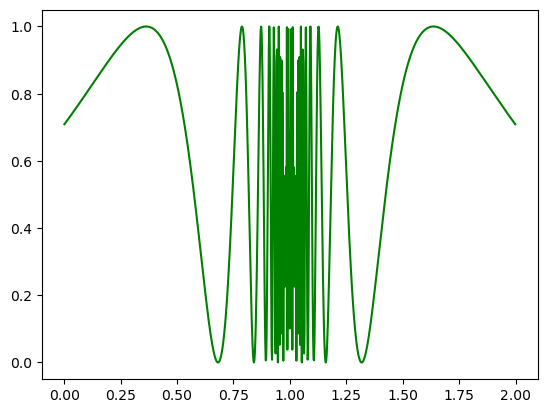

In [3]:
def f(x):
    return (np.sin(1./(1-x)))**2
x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'g-')

N=10000
semple=1000
integral_estimates = np.zeros(semple)
a,b=0,2
for i in range(semple):
    x_samples = np.random.uniform(a, b, N)
    y_samples = np.random.uniform(0, max(f(x_samples)), N)
    under_curve = y_samples < f(x_samples)
    integral_estimates[i] = (np.sum(under_curve) / N) * (b - a)

mean_estimate = np.mean(integral_estimates)
std_dev_estimate = np.std(integral_estimates, ddof=1) / np.sqrt(semple)
print('Hint/miss method')
print('Mean value :',mean_estimate)
print('Standard deviation :',std_dev_estimate)



def mean_value(x_min, x_max, n):
    X = np.random.uniform(x_min, x_max, n)
    Y = np.array([f(Xi) for Xi in X])
    s = np.sum(Y)
    integ = (x_max - x_min) / n * s
    return integ

def calc_sigma(x_min, x_max, n, m):
    integrs = np.array([mean_value(x_min, x_max, n) for mi in np.arange(m)])
    sigma = np.sqrt(np.mean(integrs**2) - np.mean(integrs)**2)
    return sigma

sigma = calc_sigma(a, b, N, semple)
integr = mean_value(a, b, N)
print('Mean value method')
print("Mean value :", integr)
print('Standard deviation :',sigma)

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [4]:
import random
n=1000000
A=0
for x in range(n):
    x=random.random()
    y=random.random()
    if x**2 + y**2 <=1:
        A +=1
print('Area of a circle :', (4*A)/n)

A = 0
x = np.zeros(10)
for i in range(n):
    x=np.array([random.random() for j in range(10)])
    if np.linalg.norm(x) <= 1:
        A += 1

print('The volume is :', (2**10 *A)/n)

Area of a circle : 3.142328
The volume is : 2.51392


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [6]:
from random import random 
from scipy.integrate import quad
f = lambda x: 1/np.sqrt(x)/(np.exp(x)+1)
w = lambda x: 1/np.sqrt(x)
invF = lambda x: x**2

def MC(N):
    const = quad(w, 0, 1)[0]
    I = 0
    for i in range(N):
        x = random()
        y = invF(x)
        I += f(y)/w(y)
    return I/N*const

print('The value of the integral is: ',MC(1000))


The value of the integral is:  0.8395570974257738
